# Receipt Scanner #

In [1]:
import os.path
import numpy as np
import scipy.ndimage as ndi
from skimage import io, color, filters, feature, segmentation, measure, draw, exposure, restoration, transform
from sklearn import cluster # scikit-learn: a machine learning library
import matplotlib as mpl
import matplotlib.pylab as plt
import cv2


In [2]:
mpl.rcParams['figure.figsize'] = (10,10)
plt.gray();


<Figure size 720x720 with 0 Axes>

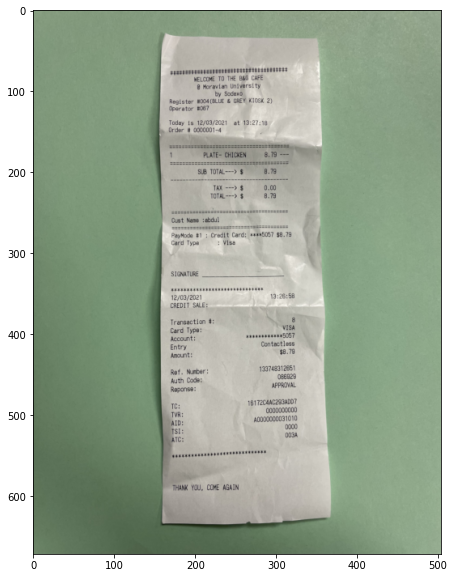

In [3]:
im = io.imread("receipt.jpg")
im = transform.rescale(im, 1/6, multichannel=True)
plt.imshow(im)

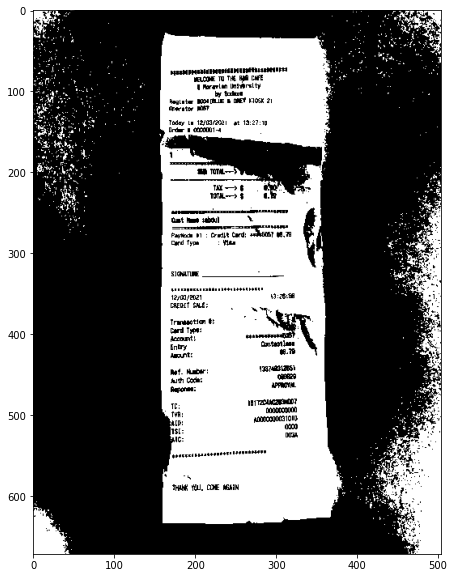

In [4]:
gray = color.rgb2gray(im)

th = gray >= filters.threshold_local(gray, 301, 'mean', 0/255)
plt.imshow(th)


In [5]:
if os.path.isdir('ImageProcessingF2021'):
    !git -C ImageProcessingF2021 pull
else:
    !git clone https://github.com/MoravianCollege/ImageProcessingF2021.git
    
from ImageProcessingF2021.utils import nonzero

Already up to date.


In [6]:
def cos(pt0, pt1, pt2):
    """
    Calculate the cosine of the angle between the vectors from pt0 to pt1 and
    pt0 to pt2. This is done using the dot product and normalization.
    """
    v1 = (pt1 - pt0).astype(float)
    v2 = (pt2 - pt0).astype(float)
    return v1.dot(v2) / np.sqrt(nonzero((v1*v1).sum()*(v2*v2).sum()))

def dist(pt0, pt1):
    """Calculates the distance between two points."""
    d = pt0-pt1
    return np.sqrt((d*d).sum())
def is_approx_rec(contour, side_length_err=0.2, cosine_err=0.25):

    contour = contour.squeeze() 
    
    # Check Basics (4 corners and convex)
    if len(contour) != 4 or not cv2.isContourConvex(contour): return False
    
    lengths = [dist(contour[i], contour[(i+1)%4]) for i in range(4)]
    short_side_1= lengths[0]
    short_side_2 = lengths[2]
    long_side_1 = lengths[1]
    long_side_2 = lengths[3]
    
    if abs(short_side_1 - short_side_2) > side_length_err*max(short_side_1, short_side_2):
        print('short side error')
        return False

    if abs(long_side_1 - long_side_2) > side_length_err*max(long_side_1, long_side_2):
        print('long side error')
        return False

    cosines = [abs(cos(contour[i], contour[(i+1)%4], contour[(i-1)%4])) for i in range(4)]
    if max(cosines) > cosine_err: return False
       
    return True


def orient_rect(contour):
    """
    Takes a contour and orients it so that 0,0 is in the top-left corner and the
    other points go clockwise around the shape. The contour must be only 4 points.
    """
    contour = contour.squeeze()
    # Find the point closest to (0,0)
    # We need to find the top-left-most coordinate
    tl_idx = (contour*contour).sum(1).argmin()
    tl = contour[tl_idx]
    # The contour is either clockwise or counter-clockwise. The point either before
    # or after the found TL point, and it will be the one with the closer y value
    br = contour[(tl_idx+2)%4]
    a,b = contour[(tl_idx+1)%4], contour[(tl_idx-1)%4]
    if abs(tl[1]-a[1]) < abs(tl[1]-b[1]):
        # Next point (a) is top-right
        return np.array([tl, a, br, b], "float32")
    else:
        # Previous point (b) is top-right
        return np.array([tl, b, br, a], "float32")

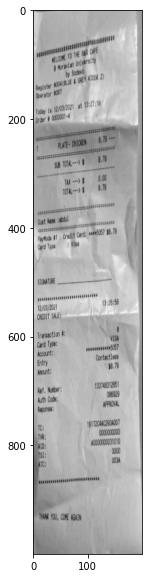

In [13]:
contours,_ = cv2.findContours(th.view('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
def largest_contour(contours):

    if len(contours) == 0: return None
    _,c = max((cv2.contourArea(c), c) for c in contours)
    return c


contour = largest_contour(contours)
if contour is None: print("Invalid") 
if cv2.contourArea(contour) < 0.25 * (im.shape[0] * im.shape[1]):print('Invalid2')


approx_perc=0.02
approx = cv2.approxPolyDP(contour, approx_perc*cv2.arcLength(contour, True), True)
if not is_approx_rec(approx, 0.2, 0.2):print('Invalid3')


WIDTH = 200
HEIGHT = 200 #TO DO * (ratio of actual receipt height to width)
dst = np.array([[0,0],[WIDTH-1,0],[WIDTH-1,HEIGHT-1],[0,HEIGHT-1]], "float32")
src = orient_rect(approx)

# # Perform the actual transformation and re-filter the image
#blur = (filters.gaussian(gray, 1.5)*255).round().astype('uint8')
trans = cv2.getPerspectiveTransform(src, dst)
receipt = cv2.warpPerspective((gray*255).round().astype('uint8'), trans, (WIDTH, HEIGHT))
#--------------------------------------------------------------
plt.imshow(receipt)

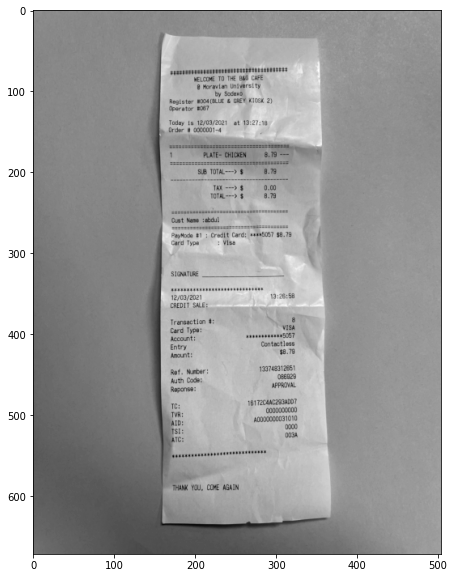

In [8]:
plt.imshow(gray)